<a href="https://colab.research.google.com/github/restful3/ds4th_study/blob/main/source/%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC/02_classification_jeong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [ ]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.1
Using datasets v2.16.0
Using accelerate v0.25.0
Using sentencepiece v0.1.99
Using umap v0.5.5


# 텍스트 분류
- 텍스트 분류는 NLP에서 매우 일반적 작업.
    - 고객 피드백을 여러 카테고리로 분류하거나 스팸메일분류, 감성분석 등
- 이번장에서는 [DistilBERT](https://arxiv.org/abs/1910.01108)를 사용해 자사제품에 드러난 감정상태를 인식하는 시스템을 만들자

<img alt="Tesla Tweet" width="500" caption="Analyzing Twitter content can yield useful feedback from customers (courtesy of Aditya Veluri)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_tweet.png?raw=1" id="tesla-tweet"/>

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_hf-libraries.png?raw=1" id="hf-libraries"/>

## 데이터셋

### 허깅 페이스 데이터셋 처음 사용하기

In [ ]:
from huggingface_hub import list_datasets

all_datasets = [ds.id for ds in list_datasets()]
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

현재 허브에는 89280개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


각 데이터셋은 고유한 이름이 있습니다. `load_dataset()` 함수로 `emotion` 데이터셋을 로드해보죠.
- [emotion 데이터셋](http://dx.doi.org/10.18653/v1/D18-1404) : 감정감지기를 개발하기 위해 영어로 작성된 트위터 메시지에 감정이 어떻게 표현되는지 연구한 논문의 데이터셋

In [ ]:
from datasets import load_dataset

# emotion 데이터셋이 다운로드되지 않으면 SetFit/emotion을 사용합니다.
emotions = load_dataset("emotion")

C:\Users\masta\.conda\envs\tw39\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# SetFit/emotion 데이터셋의 경우 수동으로 ClassLabel 객체를 만들어 label에 할당합니다.
from datasets import ClassLabel

emotions['train'].features['label'] = ClassLabel(
    num_classes=6,
    names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

16000

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned
hopeful just from being around someone who cares and is awake', 'im grabbing a
minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the
fireplace i will know that it is still on the property', 'i am feeling grouchy']


### 사이드바: 허브에 필요한 데이터셋이 없다면 어떻게 하나요?

In [ ]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [ ]:
!head -n 1 train.txt

'head'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [ ]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
                              names=["text", "label"])

In [ ]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                               names=["text", "label"])

### 사이드바 끝

### 데이터셋에서 데이터프레임으로

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
emotions["train"].features['label'].__class__

datasets.features.features.ClassLabel

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 클래스 분포 살펴 보기

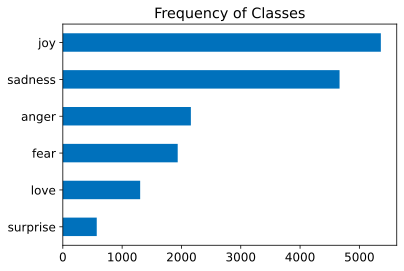

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

> 데이터셋의 불균형이 심하므로 오버샘플링 또는 언더샘플링이 필요
> - 단 훈련/테스트 셋 분할 후 훈련데이터에만 샘플링 적용 : 그렇지 않으면 많은 정보 새어나감

### 트윗 길이 확인
- maximum context size를 지정하여 최대입력 시퀀스 길이가 있음.
    - DistilBERT 는 512토큰

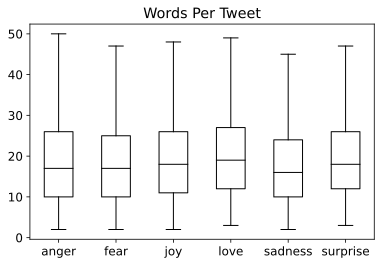

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

> 감정 별 트윗의 중간값이 15 수준이며, 최대길이도 50 이하 이므로 잘라낼 필요가 없음

In [ ]:
emotions.reset_format()

## 텍스트에서 토큰으로

### 문자 토큰
- 가장 간단한 토큰화 방법은 각 문자를 개별로 모델에 주입하는 것.

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


- 모델은 각 문자가 정수로 변환되리라 기대. 이런 과정을 수치화라 하며, 가장 쉬운 방법이 각 토큰을 고유한 정수값으로 인코딩 하는 것

In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


- 범주형 데이터를 레이블 인코딩

In [ ]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


- pd.get_dummies()로 원핫인코딩

In [ ]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


- input_ids리스틀을 텐서로 바꾸고 원핫인코딩 생성

In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [ ]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
F.one_hot(torch.tensor([0,2]), num_classes=11).shape

torch.Size([2, 11])

In [ ]:
import tensorflow as tf

tf.one_hot([0,1, 2], 1)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.]], dtype=float32)>

### 단어 토큰화

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### 부분단어 토큰화

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### 전체 데이터셋 토큰화하기

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


In [ ]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/>

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## 텍스트 분류 모델 훈련하기

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

### 트랜스포머를 특성 추출기로 사용하기

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### 사전 훈련된 모델 사용하기

In [ ]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### 사이드바: 프레임워크 간의 상호 운영성

In [ ]:
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [ ]:
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

### 사이드바 끝

#### 마지막 은닉 상태 추출하기

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [ ]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [ ]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#### 특성 행렬 만들기

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### 훈련 세트 시각화하기

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.461250,6.628591,0
1,-2.837784,6.028275,0
2,5.428299,3.168764,3
3,-2.060799,3.928995,2
4,-3.168155,3.763369,3


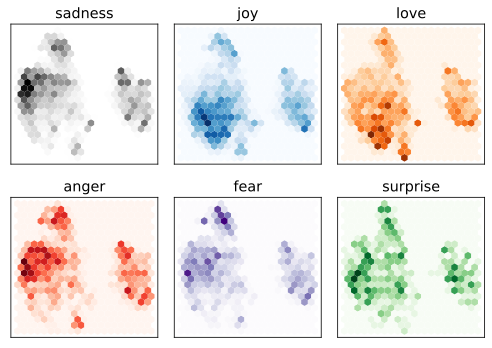

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### 간단한 분류 모델 훈련하기

In [ ]:
# 수렴을 보장하기 위해 `max_iter`를 증가시킵니다.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.633

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

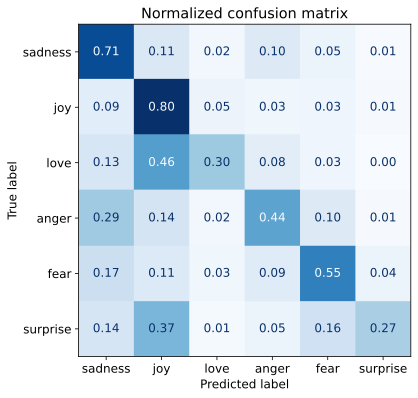

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 트랜스포머 미세 튜닝하기

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

#### 사전 훈련된 모델 로드하기

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

#### 성공 지표 정의하기

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### 모델 훈련하기

[엑세스토큰만드는방법](https://oreil.ly/IRkN1)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

NameError: name 'trainer' is not defined

In [ ]:
preds_output.metrics

{'test_loss': 0.21486791968345642,
 'test_accuracy': 0.9275,
 'test_f1': 0.9276833250887557,
 'test_runtime': 3.8794,
 'test_samples_per_second': 515.546,
 'test_steps_per_second': 8.249}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

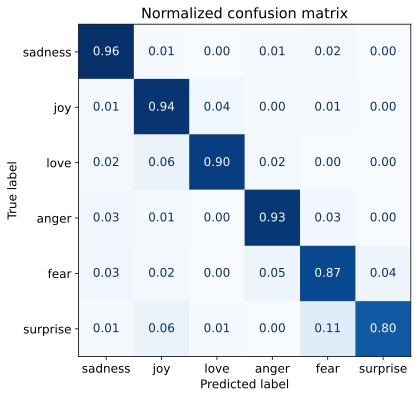

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plot_confusion_matrix(y_preds, y_valid, labels)

### 사이드바: 케라스로 미세 튜닝하기

In [ ]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
# 텐서플로 텐서로 변환할 열 이름
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols="label", shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols="label", shuffle=False,
    batch_size=batch_size)

In [ ]:
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
250/250 [==============================] - 1279s 5s/step - loss: 0.5281 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.1899 - val_sparse_categorical_accuracy: 0.9270
Epoch 2/2
180/250 [====================>.........] - ETA: 5:27 - loss: 0.1543 - sparse_categorical_accuracy: 0.9351

### 사이드바 끝

#### 오류 분석

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.583548
1950,i as representative of everything thats wrong ...,surprise,sadness,5.544038
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.372250
1801,i feel that he was being overshadowed by the s...,love,sadness,5.259750
1274,i am going to several holiday parties and i ca...,joy,sadness,5.110855
465,i would eventually go in to these stores but i...,joy,fear,5.077787
1509,i guess this is a memoir so it feels like that...,joy,fear,5.030020
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.942071
765,i feel super awkward and out of place right now,joy,sadness,4.792200
177,im sure much of the advantage is psychological...,sadness,joy,4.532534


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.014904
11,i was dribbling on mums coffee table looking o...,joy,joy,0.014992
632,i feel he is an terrific really worth bet,joy,joy,0.015079
131,i feel like a graph doesnt show the data accur...,joy,joy,0.015180
669,i am not feeling very joyful today its been a ...,joy,joy,0.015305
1873,i feel practically virtuous this month i have ...,joy,joy,0.015341
1780,ive explained that he is very creative and lov...,joy,joy,0.015341
1263,i feel this way about blake lively,joy,joy,0.015400
845,i already feel very glamorous have a great day...,joy,joy,0.015598
260,i am feeling so invigorated and so ready to ke...,joy,joy,0.015680


#### 모델 저장 및 공유

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/wooseok0303/distilbert-base-uncased-finetuned-emotion/tree/main/'

In [ ]:
from transformers import pipeline

model_id = "wooseok0303/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_tweet = "I saw a movie today and it was just not bad."
preds = classifier(custom_tweet, top_k=None)

In [ ]:
preds_sorted = sorted(preds, key=lambda d: d['label'])
preds_df = pd.DataFrame(preds_sorted)
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()